# **Analisi dei flussi degli utenti Vodafone**

Lo studio dei flussi di persone all'interno delle aree urbane è di fondamentale importanza per comprendere al meglio le criticità emergenti nella mobilità locale e per esplorare le aree di potenziale miglioramento delle infrastrutture e dei trasporti locali.<br>
La mobilità degli utenti all'interno e verso Padova è stata monitorata utilizzando i dati forniti dal gestore di telefonia mobile Vodafone, che fornisce informazioni basate sulle connessioni degli utenti alle celle della rete.<br>
I dati forniti dal carrier comprendono il monitoraggio degli utenti connessi alla rete Vodafone di Padova in un periodo di quattro mesi, da febbraio a maggio 2018.<br>
Per fornire approfondimenti statistici sul numero e sul flusso di utenti, i dati sono stati aggregati in base all'origine e ai movimenti degli utenti, calcolando la media del numero di connessioni durante il periodo di monitoraggio.<br>
Per evitare ulteriori problemi di violazione della privacy, tutte le osservazioni con meno di 30 unità (ad esempio le aree giornaliere per le quali <30 utenti hanno contribuito) sono state scartate e/o accorpate in categorie dedicate (indicate con "altro").<br>

## **Set di dati** 

I dataset si trovano al seguente link: https://www.dropbox.com/scl/fo/jra3xy77imdqc6hjc8luu/h?dl=0&rlkey=3ui6k9bhie88zxsk70zs317ow . La cartella comprende parecchi dati, si invita ad anallizzarli adeguatamente alle esigenze del problema ed eventualmente scartare dati inutili ai fini del progetto. I dati sono in diversi formati ed alcuni di questi sono descritti di seguito.

* __day_od.csv__: tabella delle origini e delle destinazioni degli utenti mediate per giorno della settimana. I dati sono forniti con il dettaglio del mese, del tipo di utente (residente a Padova/visitatore italiano/visitatore straniero), del Paese di provenienza, insieme alla provincia e al comune dell'utente (se disponibili).
* __utenti_distinti_giorno.csv__: tabella del numero di utenti distinti per provenienza. I dati sono forniti con il dettaglio del mese, del tipo di utente (residente a Padova/visitatore italiano/visitatore straniero), del Paese di provenienza, insieme alla provincia e al comune dell'utente (se disponibili).

Le informazioni sono memorizzate nei campi secondo il seguente schema: 

- MONTH: mese analizzato
- DOW: giorno analizzato
- ORIGIN: area di provenienza dell'utente
- DESTINATION: area di destinazione dell'utente
- CUST_CLASS: tipo di utente (residente / visitatore italiano / visitatore straniero)
- COD_COUNTRY: codice paese dell'utente (es. 222=Italia)
- COD_PRO: codice della provincia dell'utente (ad es. 12=Varese) 
- PRO_COM: codice del comune dell'utente (es. 12026=Busto Arsizio)
- FLOW: numero di movimenti per una determinata data-ora (con un minimo di 30 utenti)
- VISITORS: numero complessivo di utenti 

Insieme ai file di dati, vengono fornite tre tabelle di ricerca che permettono di abbinare i codici ISTAT di paese, provincia e comune ai nomi reali.

* __codici_istat_comune.csv__: file di lookup contenente la mappatura dei codici ISTAT dei comuni
* __codici_istat_provincia.csv__: file di ricerca contenente la mappatura dei codici ISTAT della provincia
* __codici_nazioni.csv__: file di lookup contenente la mappatura del codice _paese_ con il suo nome

Ulteriori informazioni, utili per lo studio dei flussi di utenti, come il numero di abitanti di ogni provincia e la distanza tra Padova e tutte le altre province italiane, possono essere estratte sulla base dei dati raccolti dall'ISTAT (es. http://dati.istat.it/Index.aspx?lang=en&SubSessionId=bcd553a8-280a-4b08-afee-cf7a72fd2ad9, http://www.istat.it/storage/cartografia/matrici_distanze/Veneto.zip).


## Assegnazione

1. Preparazione dei dati: i file csv provengono da fonti diverse e quindi presentano differenze di codifica e di fine riga che devono essere prese in considerazione nella fase di preparazione dei dati. Assicurarsi che ogni file .csv sia interpretato correttamente.
* Classifica dei visitatori provenienti da paesi stranieri: in base al numero di visitatori totali per ogni paese, creare una classifica dei primi 20 paesi con il maggior numero di visitatori.
* Classifica dei visitatori italiani per provincia, ponderata per il numero di abitanti: in base al numero di visitatori totali per provincia italiana, creare una classifica delle prime 20 province con più visitatori tenendo conto del numero di abitanti.
* Studio dei flussi di visitatori: ipotizziamo di essere chiamati a fornire indicazioni su come investire risorse per migliorare la mobilità verso Padova. Definite le tre principali direzioni dei visitatori e dei pendolari che raggiungono Padova attraverso le autostrade italiane (sud: A13 verso Bologna-Roma / ovest: A4 verso Milano-Torino / nord-est: A4 verso Venezia-Trieste), valutare quale delle tre direzioni deve essere privilegiata:
 1. Considerare un caso semplificato che coinvolge solo la mobilità di fascia media, in base al numero di visitatori/pendolari provenienti solo dalle regioni vicine
 2. Considerare le province situate sulle tre direzioni che contribuiscono maggiormente al flusso di visitatori del fine settimana e di pendolari giornalieri, effettuando uno studio più dettagliato dei flussi in base al giorno della settimana.
 3. Utilizzate i dati disponibili per fornire quella che ritenete la migliore risposta possibile. 
* Tracciare la distribuzione del numero di visitatori in base alla distanza della provincia di origine. Determinare il tipo di legge da utilizzare per descrivere la distribuzione.
 * Supponendo che si possa usare una forma analitica per descrivere l'andamento, create una regressione per stimare il numero atteso di visitatori in base alla distanza della provincia di origine. Illustrare la differenza tra la regressione ottenuta e i numeri forniti dal monitoraggio Vodafone, evidenziando le cinque discrepanze più evidenti rispetto alle aspettative.
* Utilizzate tutti i dati disponibili (ed eventualmente quelli aggiuntivi di fonte ISTAT) per estrarre un'altra informazione interessante sulla mobilità e sul flusso di visitatori e pendolari.

In [367]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [368]:
df_day = pd.read_csv("DATA/day_od.csv")
df_distinct_users = pd.read_csv("DATA/distinct_users_day.csv", encoding="ANSI")
df_provincie = pd.read_csv("DATA/codici_istat_provincia.csv", encoding="ANSI")
df_comuni = pd.read_csv("DATA/codici_istat_comune.csv", encoding="ANSI")
df_nazioni = pd.read_csv("DATA/codici_nazioni.csv", encoding="ANSI")
df_population_data = pd.read_csv("DATA/DCIS_POPRES1_28032023144458463.csv")
df_population_data = df_population_data.loc[:, ["Territorio", "Value"]]
df_population_data.drop(11, inplace=True) # rimuovo il doppione di valle d'aosta

#df_day[(df_day.MONTH == "Marzo") & (df_day.DOW == "Martedì")]


In [369]:
df_population_data

,Territorio,Value
0,Italia,59030133
1,Nord-ovest,15831941
2,Piemonte,4256350
3,Torino,2208370
4,Vercelli,166083
...,...,...
130,Agrigento,415887
131,Siracusa,385900
132,Oristano,151655
133,Monza e della Brianza,870407


In [370]:
df_provincie

,COD_REG,COD_PRO,PROVINCIA,PROV_SIGLA
0,1,1,Torino,TO
1,1,2,Vercelli,VC
2,1,3,Novara,NO
3,1,4,Cuneo,CN
4,1,5,Asti,AT
...,...,...,...,...
103,20,91,Nuoro,NU
104,20,92,Cagliari,CA
105,20,95,Oristano,OR
106,20,111,Sud Sardegna,SU


aggiungiamo i nomi dei comuni, provincie ecc al df

In [371]:
df_distinct_users

,DOW,CUST_CLASS,COD_COUNTRY,COD_PRO,PRO_COM,VISITORS
0,Mercoledì,visitor,222.0,35.0,35033.0,968
1,Lunedì,visitor,222.0,22.0,22098.0,64
2,Domenica,visitor,222.0,52.0,52032.0,516
3,Giovedì,visitor,222.0,108.0,108009.0,128
4,Giovedì,visitor,222.0,29.0,29048.0,512
...,...,...,...,...,...,...
12840,Mercoledì,foreigner,259.0,NaN,NaN,176
12841,Sabato,foreigner,602.0,NaN,NaN,164
12842,Giovedì,foreigner,732.0,NaN,NaN,80
12843,Giovedì,foreigner,297.0,NaN,NaN,80


In [372]:
df_distinct_users["COD_PRO"].map(df_provincie.set_index("COD_PRO")["PROVINCIA"])

0           Reggio nell'Emilia
1                       Trento
2                        Siena
3        Monza e della Brianza
4                       Rovigo
                 ...          
12840                      NaN
12841                      NaN
12842                      NaN
12843                      NaN
12844                      NaN
Name: COD_PRO, Length: 12845, dtype: object

In [373]:
df_distinct_users["PROVINCIA"] = df_distinct_users["COD_PRO"].map(df_provincie.set_index("COD_PRO")["PROVINCIA"])
df_distinct_users["COD_REG"] = df_distinct_users["COD_PRO"].map(df_provincie.set_index("COD_PRO")["COD_REG"])
df_distinct_users["COMUNE"] = df_distinct_users["PRO_COM"].map(df_comuni.set_index("PRO_COM")["COMUNE"])
df_distinct_users["COUNTRY"] = df_distinct_users["COD_COUNTRY"].map(df_nazioni.set_index("COD_COUNTRY")["COUNTRY_NAME_IT"])
df_distinct_users["VALUE"] = df_distinct_users["PROVINCIA"].map(df_population_data.set_index("Territorio")["Value"])
df_distinct_users

,DOW,CUST_CLASS,COD_COUNTRY,COD_PRO,PRO_COM,VISITORS,PROVINCIA,COD_REG,COMUNE,COUNTRY,VALUE
0,Mercoledì,visitor,222.0,35.0,35033.0,968,Reggio nell'Emilia,8.0,Reggio nell'Emilia,Italia,525586.0
1,Lunedì,visitor,222.0,22.0,22098.0,64,Trento,4.0,Isera,Italia,540958.0
2,Domenica,visitor,222.0,52.0,52032.0,516,Siena,9.0,Siena,Italia,261209.0
3,Giovedì,visitor,222.0,108.0,108009.0,128,Monza e della Brianza,3.0,Biassono,Italia,870407.0
4,Giovedì,visitor,222.0,29.0,29048.0,512,Rovigo,5.0,Villadose,Italia,228902.0
...,...,...,...,...,...,...,...,...,...,...,...
12840,Mercoledì,foreigner,259.0,NaN,NaN,176,NaN,NaN,NaN,Moldova,NaN
12841,Sabato,foreigner,602.0,NaN,NaN,164,NaN,NaN,NaN,Egitto,NaN
12842,Giovedì,foreigner,732.0,NaN,NaN,80,NaN,NaN,NaN,Colombia,NaN
12843,Giovedì,foreigner,297.0,NaN,NaN,80,NaN,NaN,NaN,Montenegro,NaN


In [374]:
#primi 20 paesi stranieri con più visitatori
df_foreign_data = df_distinct_users[df_distinct_users.COUNTRY != "Italia"]
grouped_df_foreign_data = df_foreign_data.groupby(by="COUNTRY").sum().sort_values("VISITORS", ascending=False).iloc[:20, :]
grouped_df_foreign_data

,COD_COUNTRY,COD_PRO,PRO_COM,VISITORS,COD_REG,VALUE
COUNTRY,,,,,,
Francia,1456.0,0.0,0.0,129672,0.0,0.0
Svizzera,1596.0,0.0,0.0,116884,0.0,0.0
Germania,1834.0,0.0,0.0,109176,0.0,0.0
Cina,3220.0,0.0,0.0,107796,0.0,0.0
Austria,1624.0,0.0,0.0,96776,0.0,0.0
Stati Uniti d'America,4347.0,0.0,0.0,76136,0.0,0.0
Spagna,1498.0,0.0,0.0,71872,0.0,0.0
Paesi Bassi,1428.0,0.0,0.0,70432,0.0,0.0
Romania,1582.0,0.0,0.0,59012,0.0,0.0


In [375]:
df_distinct_users

,DOW,CUST_CLASS,COD_COUNTRY,COD_PRO,PRO_COM,VISITORS,PROVINCIA,COD_REG,COMUNE,COUNTRY,VALUE
0,Mercoledì,visitor,222.0,35.0,35033.0,968,Reggio nell'Emilia,8.0,Reggio nell'Emilia,Italia,525586.0
1,Lunedì,visitor,222.0,22.0,22098.0,64,Trento,4.0,Isera,Italia,540958.0
2,Domenica,visitor,222.0,52.0,52032.0,516,Siena,9.0,Siena,Italia,261209.0
3,Giovedì,visitor,222.0,108.0,108009.0,128,Monza e della Brianza,3.0,Biassono,Italia,870407.0
4,Giovedì,visitor,222.0,29.0,29048.0,512,Rovigo,5.0,Villadose,Italia,228902.0
...,...,...,...,...,...,...,...,...,...,...,...
12840,Mercoledì,foreigner,259.0,NaN,NaN,176,NaN,NaN,NaN,Moldova,NaN
12841,Sabato,foreigner,602.0,NaN,NaN,164,NaN,NaN,NaN,Egitto,NaN
12842,Giovedì,foreigner,732.0,NaN,NaN,80,NaN,NaN,NaN,Colombia,NaN
12843,Giovedì,foreigner,297.0,NaN,NaN,80,NaN,NaN,NaN,Montenegro,NaN


aggiungiamo le autostrade

In [376]:
venezia_trieste_A4 = [5, 6]
torino_milano_A4 = [1, 2, 3, 4, 7]
bologna_roma_A4 = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
#df_venezia_trieste_A4_provincie = [df_provincie[df_provincie.COD_REG == x].PROVINCIA for x in venezia_trieste_A4]
#df_torino_milano_A4_provincie = [df_provincie[df_provincie.COD_REG == x].PROVINCIA for x in torino_milano_A4]
#df_bologna_roma_A4_provincie = [df_provincie[df_provincie.COD_REG == x].PROVINCIA for x in bologna_roma_A4]

In [377]:
df_distinct_users["AUTOSTRADA"] = df_distinct_users.loc[:, "COD_REG"]

In [378]:
df_distinct_users["AUTOSTRADA"] = df_distinct_users["AUTOSTRADA"].map(lambda x : 0 if x in venezia_trieste_A4 else x)
df_distinct_users["AUTOSTRADA"] = df_distinct_users["AUTOSTRADA"].map(lambda x : 1 if x in torino_milano_A4 else x)
df_distinct_users["AUTOSTRADA"] = df_distinct_users["AUTOSTRADA"].map(lambda x : 2 if x in bologna_roma_A4 else x)

In [379]:
df_grouped_by_road = df_distinct_users.groupby(by=["AUTOSTRADA", "DOW"]).agg({"VISITORS": "sum", "COD_REG": "count"})
df_grouped_by_road

VISITORS  COD_REG
AUTOSTRADA DOW                         
0.0        Domenica     720796      578
           Giovedì      694828      580
           Lunedì       695136      572
           Martedì      702304      578
           Mercoledì    719856      583
           Sabato       740608      585
           Venerdì      725392      589
1.0        Domenica      84732      606
           Giovedì       73824      558
           Lunedì        71724      558
           Martedì       72608      566
           Mercoledì     76292      583
           Sabato        84904      615
           Venerdì       84820      609
2.0        Domenica      97900      609
           Giovedì       76848      548
           Lunedì        80312      580
           Martedì       80036      587
           Mercoledì     81688      604
           Sabato        98132      591
           Venerdì       89020      590

In [380]:
df_grouped_by_road.reset_index()

,AUTOSTRADA,DOW,VISITORS,COD_REG
0,0.0,Domenica,720796,578
1,0.0,Giovedì,694828,580
2,0.0,Lunedì,695136,572
3,0.0,Martedì,702304,578
4,0.0,Mercoledì,719856,583
5,0.0,Sabato,740608,585
6,0.0,Venerdì,725392,589
7,1.0,Domenica,84732,606
8,1.0,Giovedì,73824,558
9,1.0,Lunedì,71724,558


In [381]:
df_distinct_users = df_distinct_users.dropna(subset=["COD_PRO"])

es 2 trovati visitatori per provincia ponderata per popolazione

In [382]:
lista = []
for code in df_distinct_users.COD_PRO.unique():
    lista.append((df_distinct_users[df_distinct_users["COD_PRO"] == code].VISITORS.sum() / 
                  df_distinct_users[df_distinct_users["COD_PRO"] == code].VALUE.iloc[0] , 
                  df_distinct_users[df_distinct_users["COD_PRO"] == code].PROVINCIA.iloc[0]))

In [383]:
df_rapporti = pd.DataFrame(lista , columns=["Rapporto", "PROVINCIA"])
# capire i nan
df_rapporti.isna().sum()

Rapporto     5
PROVINCIA    3
dtype: int64

In [384]:
# classifica delle prime 20 province per rapporto tra visitatori e popolazione
df_rapporti.sort_values(by="Rapporto", ascending=False).reset_index(drop=True).head(20)

,Rapporto,PROVINCIA
0,3.364067,Padova
1,0.741097,Venezia
2,0.714122,Rovigo
3,0.506903,Vicenza
4,0.361348,Treviso
5,0.236526,Belluno
6,0.196536,Verona
7,0.158529,Ferrara
8,0.123668,Pordenone
9,0.120431,Trento


In [385]:
venezia_trieste_A4 = [5, 6]
torino_milano_A4 = [1, 2, 3, 4, 7]
bologna_roma_A4 = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [386]:
venezia_trieste_prinvince_A4 =[23,24,25,26,27,28,29,30,31,32,93]

In [387]:
"""i = 0
for code in df_distinct_users.dropna(subset=["COD_PRO"])["COD_PRO"].unique():
    print(df_distinct_users.dropna(subset=["COD_PRO"])[df_distinct_users.dropna(subset=["COD_PRO"])["COD_PRO"] == code].VISITORS.sum() / df_distinct_users.dropna(subset=["COD_PRO"])[df_distinct_users.dropna(subset=["COD_PRO"])["COD_PRO"] == code].VALUE.iloc[0])
    print(i)
    i += 1"""

'i = 0\nfor code in df_distinct_users.dropna(subset=["COD_PRO"])["COD_PRO"].unique():\n    print(df_distinct_users.dropna(subset=["COD_PRO"])[df_distinct_users.dropna(subset=["COD_PRO"])["COD_PRO"] == code].VISITORS.sum() / df_distinct_users.dropna(subset=["COD_PRO"])[df_distinct_users.dropna(subset=["COD_PRO"])["COD_PRO"] == code].VALUE.iloc[0])\n    print(i)\n    i += 1'

In [388]:
df_distinct_users.dropna(subset=["COD_PRO"])["COD_PRO"]

0         35.0
1         22.0
2         52.0
3        108.0
4         29.0
         ...  
12828     65.0
12829     22.0
12830     16.0
12831     78.0
12832     38.0
Name: COD_PRO, Length: 12312, dtype: float64

In [389]:
df_distinct_users

,DOW,CUST_CLASS,COD_COUNTRY,COD_PRO,PRO_COM,VISITORS,PROVINCIA,COD_REG,COMUNE,COUNTRY,VALUE,AUTOSTRADA
0,Mercoledì,visitor,222.0,35.0,35033.0,968,Reggio nell'Emilia,8.0,Reggio nell'Emilia,Italia,525586.0,2.0
1,Lunedì,visitor,222.0,22.0,22098.0,64,Trento,4.0,Isera,Italia,540958.0,1.0
2,Domenica,visitor,222.0,52.0,52032.0,516,Siena,9.0,Siena,Italia,261209.0,2.0
3,Giovedì,visitor,222.0,108.0,108009.0,128,Monza e della Brianza,3.0,Biassono,Italia,870407.0,1.0
4,Giovedì,visitor,222.0,29.0,29048.0,512,Rovigo,5.0,Villadose,Italia,228902.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12828,Martedì,visitor,222.0,65.0,65052.0,36,Salerno,15.0,Fisciano,Italia,1064493.0,2.0
12829,Giovedì,visitor,222.0,22.0,22017.0,40,Trento,4.0,Bleggio Superiore,Italia,540958.0,1.0
12830,Martedì,visitor,222.0,16.0,16053.0,36,Bergamo,3.0,Caravaggio,Italia,1102997.0,1.0
12831,Venerdì,visitor,222.0,78.0,78031.0,36,Cosenza,18.0,Castrolibero,Italia,674543.0,2.0


In [390]:
df_distinct_users.COD_PRO.unique()

array([ 35.,  22.,  52., 108.,  29.,  27.,  89.,  20.,  28.,  98.,  24.,
        26.,  12.,  15.,  39.,  72.,  37.,  19.,  62.,  25.,  23.,   3.,
        14.,   1.,  81.,  92.,  31.,  78.,  17.,  93.,  58.,  16.,  21.,
        71.,  34.,  83.,   8., 104.,  42.,  73.,   9.,  36.,  97.,  30.,
        13.,  38.,  55.,  68.,   7., 103.,  18.,  10.,  41.,  67.,  87.,
       110., 109.,  50.,  32.,  63.,  60.,   6.,  77.,  82.,  65.,  46.,
        74.,  76.,  40.,  75.,   4.,  59.,  99.,  61.,  54.,  69.,  48.,
        90.,  45., 100.,  96.,  80.,  95.,  43.,  49.,  44.,  70.,  64.,
        88.,  47.,   2.,  53.,  66.,  79.,  56.,  11., 107.,  51.,  86.,
        33.,   5.,  85.,  84., 101.,  91., 102.,  57., 105.])

In [391]:
##replace nation number with string names
#nation_dictionary = {key: val for key, val in zip(df_nazioni.COD_COUNTRY, df_nazioni.COUNTRY_NAME_IT)}
#provincie_dictionary = {key: val for key, val in zip(df_provincie.COD_PRO, df_provincie.PROVINCIA)}
#comuni_dictionary = {key: val for key, val in zip(df_comuni.PRO_COM, df_comuni.COMUNE)}
#
#df_day.COUNTRY = df_day.COD_COUNTRY.replace(nation_dictionary)
#df_day.PRO = df_day.COD_PRO.replace(provincie_dictionary)
#df_day.COM = df_day.PRO_COM.replace(comuni_dictionary)
#
#df_distinct_users.COD_COUNTRY = df_distinct_users.COD_COUNTRY.replace(nation_dictionary)
#df_distinct_users.COD_PRO = df_distinct_users.COD_PRO.replace(provincie_dictionary)
#df_distinct_users.PRO_COM = df_distinct_users.PRO_COM.replace(comuni_dictionary)
#df_distinct_users

In [392]:
"""grouped_df_foreign_data.reset_index(inplace=True)
grouped_df_foreign_data
grouped_df_foreign_data["COD_COUNTRY"] = grouped_df_foreign_data["COD_COUNTRY"].apply(lambda x: df_nazioni[df_nazioni.COD_COUNTRY == x].COUNTRY_NAME_IT.values[0])
grouped_df_foreign_data"""

'grouped_df_foreign_data.reset_index(inplace=True)\ngrouped_df_foreign_data\ngrouped_df_foreign_data["COD_COUNTRY"] = grouped_df_foreign_data["COD_COUNTRY"].apply(lambda x: df_nazioni[df_nazioni.COD_COUNTRY == x].COUNTRY_NAME_IT.values[0])\ngrouped_df_foreign_data'

In [393]:
df_distinct_users[df_distinct_users.PROVINCIA == "Rovigo"].VISITORS.sum()

163464

In [394]:
df_distinct_users[df_distinct_users.PROVINCIA == "Vicenza"].VISITORS.sum()

431952

In [395]:
df_distinct_users[df_distinct_users.PROVINCIA == "Verona"].VISITORS.sum()

181604

In [396]:
"""df_population_data = pd.read_csv("DATA/DCIS_POPRES1_28032023144458463.csv")
df_population_data = df_population_data.loc[:, ["Territorio", "Value"]]
df_provincie"""

'df_population_data = pd.read_csv("DATA/DCIS_POPRES1_28032023144458463.csv")\ndf_population_data = df_population_data.loc[:, ["Territorio", "Value"]]\ndf_provincie'

In [397]:
"""df_distance_from_padova = df_distance_from_padova[df_distance_from_padova.Destinazione == "28060,00"]
df_distance_from_padova
df_comuni"""

'df_distance_from_padova = df_distance_from_padova[df_distance_from_padova.Destinazione == "28060,00"]\ndf_distance_from_padova\ndf_comuni'

In [398]:
venezia_trieste_A4 = [5, 6]
df = [df_provincie[df_provincie.COD_REG == x].PROVINCIA for x in range(5, 7)]
torino_milano_A4 = [1, 2, 3, 4, 7]
bologna_roma_A4 = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [399]:
confinanti = [3, 4, 6, 8] # codici delle regioni confinanti con il veneto

In [400]:
df_day["COD_REG"] = df_day["COD_PRO"].map(df_provincie.set_index("COD_PRO")["COD_REG"])# aggiunta del codice regione al df day

In [401]:
# filtraggio per visitatori con un flusso medio 
df_day.loc[(df_day["CUST_CLASS"] != "resident") & (df_day["FLOW"] <= 200) & (df_day["COD_REG"].isin(confinanti))]

,MONTH,DOW,ORIGIN,DESTINATION,CUST_CLASS,COD_COUNTRY,COD_PRO,PRO_COM,FLOW,COD_REG
1,Maggio,Lunedì,300,101,visitor,222,93.0,-999.0,58,6.0
12,Maggio,Mercoledì,300,101,visitor,222,20.0,-999.0,45,3.0
55,Febbraio,Martedì,300,118,visitor,222,15.0,-999.0,65,3.0
58,Aprile,Mercoledì,106,126,visitor,222,15.0,-999.0,33,3.0
61,Aprile,Martedì,107,300,visitor,222,15.0,-999.0,36,3.0
...,...,...,...,...,...,...,...,...,...,...
193411,Marzo,Mercoledì,102,300,visitor,222,21.0,21008.0,32,4.0
193438,Maggio,Mercoledì,125,300,visitor,222,15.0,-999.0,32,3.0
193471,Febbraio,Lunedì,121,300,visitor,222,32.0,32006.0,32,6.0
193481,Maggio,Martedì,109,300,visitor,222,15.0,-999.0,36,3.0


<AxesSubplot:>

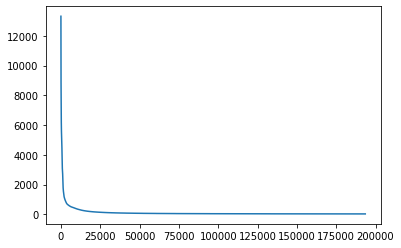

In [402]:
df_day["FLOW"].sort_values(ascending=False).reset_index(drop=True).plot()

In [403]:
df_day["FLOW"]

0         493
1          58
2          39
3         106
4         136
         ... 
193496     32
193497     32
193498     40
193499     36
193500     32
Name: FLOW, Length: 193501, dtype: int64

In [404]:
df_day[df_day["FLOW"] < 50]["FLOW"]

2         39
8         46
10        43
12        45
19        48
          ..
193496    32
193497    32
193498    40
193499    36
193500    32
Name: FLOW, Length: 109018, dtype: int64

In [405]:
incidenti_df = pd.read_csv("INCSTRAD_2018_IT_TXT-20230522T140153Z-001\INCSTRAD_2018_IT_TXT\MICRODATI\INCSTRAD_Microdati_2018.txt" , sep="\t")
incidenti_df

C:\Users\Utente\AppData\Local\Temp\ipykernel_20852\1173696417.py:1: DtypeWarning: Columns (6,7,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  incidenti_df = pd.read_csv("INCSTRAD_2018_IT_TXT-20230522T140153Z-001\INCSTRAD_2018_IT_TXT\MICRODATI\INCSTRAD_Microdati_2018.txt" , sep="\t")


,anno,provincia,comune,giorno,organo_di_rilevazione,localizzazione_incidente,denominazione_della_strada,tronco_di_strada_o_autostrada,tipo_di_strada,pavimentazione,intersezione_o_non_interse3,fondo_stradale,segnaletica,condizioni_meteorologiche,natura_incidente,tipo_veicolo_a,tipo_veicoli__b_,tipo_veicolo__c_,veicolo__a____circostanze_10,veicolo__a____circostanze_11,veicolo__b____circostanze_13,veicolo__b____circostanze_14,veicolo__a___anno_immatric18,immatricolazione_veicolo__b_,immatricolazione_veicolo__c_,veicolo__a___et__conducente,veicolo__a___sesso_conducente,veicolo__a___esito_conducente,veicolo__a___patente_condu29,veicolo__a___anno_rilascio30,veicolo__a___passeggeri_an35,veicolo__a___et__passegger36,veicolo__a___sesso_passegg37,veicolo__a___esito_passegg38,veicolo__a___et__passegger39,veicolo__a___sesso_passegg40,veicolo__a___esito_passegg41,veicolo__a___et__passegger42,veicolo__a___sesso_passegg43,veicolo__a___esito_passegg44,veicolo__a___et__passegger45,veicolo__a___sesso_passegg46,veicolo__a___altri_passegg47,veicolo__a___altri_passegg48,veicolo__a___altri_passegg49,veicolo__a___altri_passegg50,veicolo__b___et__conducente,veicolo__b___sesso_conducente,veicolo__b___esito_conducente,veicolo__b___patente_condu51,veicolo__b___anno_rilascio52,veicolo__b___passeggeri_an57,veicolo__b___et__passegger58,veicolo__b___sesso_passegg59,veicolo__b___esito_passegg60,veicolo__b___et__passegger61,veicolo__b___sesso_passegg62,veicolo__b___esito_passegg63,veicolo__b___et__passegger64,veicolo__b___sesso_passegg65,veicolo__b___esito_passegg66,veicolo__b___et__passegger67,veicolo__b___sesso_passegg68,veicolo__b___altri_passegg69,veicolo__b___altri_passegg70,veicolo__b___altri_passegg71,veicolo__b___altri_passegg72,veicolo__c___et__conducente,veicolo__c___sesso_conducente,veicolo__c___esito_conducente,veicolo__c___patente_condu73,veicolo__c___anno_rilascio74,veicolo__c___passeggeri_an79,veicolo__c___et__passegger80,veicolo__c___sesso_passegg81,veicolo__c___esito_passegg82,veicolo__c___et__passegger83,veicolo__c___sesso_passegg84,veicolo__c___esito_passegg85,veicolo__c___et__passegger86,veicolo__c___sesso_passegg87,veicolo__c___esito_passegg88,veicolo__c___et__passegger89,veicolo__c___sesso_passegg90,veicolo__c___altri_passegg91,veicolo__c___altri_passegg92,veicolo__c___altri_passegg93,veicolo__c___altri_passegg94,pedone_morto_1__sesso,pedone_morto_1__et_,pedone_ferito_1__sesso,pedone_ferito_1__et_,pedone_morto_2__sesso,pedone_morto_2__et_,pedone_ferito_2__sesso,pedone_ferito_2__et_,pedone_morto_3__sesso,pedone_morto_3__et_,pedone_ferito_3__sesso,pedone_ferito_3__et_,pedone_morto_4__sesso,pedone_morto_4__et_,pedone_ferito_4__sesso,pedone_ferito_4__et_,altri_veicoli_coinvolti,morti_maschi_coinvolti_su_95,morti_femmine_coinvolti_su96,feriti_maschi_coinvolti_su97,feriti_femmine_coinvolti_s98,morti_entro_24_ore,morti_entro_30_giorni,feriti,descrizione_strada,Ora,chilometri,ettometrica,trimestre
0,18,83,9,1,2,5,147,12,2,1,8,3,4,1,10,1,,,72,,74,,,,,18-29,1,1,2,"(2013,2018]",2,18-29,3,,,,,,,,,,0,0,0,0,,,,,,,,,,,,,,,,,,0,0,0,0,,,,,,,,,,,,,,,,,,0,0,0,0,,,,,,,,,,,,,,,,,0,0,0,0,0,0,0,1,...,1,0000,000,1
1,18,60,6,1,2,2,056,12,2,1,7,1,2,1,2,1,01,,25,,20,,,2015,,45-54,1,2,2,"(2008,2013]",,,,2,30-44,4,2,10-14,3,2,15-17,3,0,0,0,0,30-44,1,2,2,,,,,2,30-44,4,2,0-5,4,,,,0,0,0,0,,,,,,,,,,,,,,,,,,0,0,0,0,,,,,,,,,,,,,,,,,0,0,0,0,0,0,0,7,...,3,0000,500,1
2,18,9,6,1,2,3,001,12,2,1,7,2,4,3,2,1,01,,21,,20,,2011,,,45-54,1,2,2,"(1984,1988]",,,,,,,,,,,,,0,0,0,0,30-44,1,2,2,"(1988,1993]",2,30-44,4,2,10-14,3,2,6-9,4,,,,0,0,0,0,,,,,,,,,,,,,,,,,,0,0,0,0,,,,,,,,,,,,,,,,,0,0,0,0,0,0,0,5,...,3,0000,000,1
3,18,95,18,1,2,1,000,12,2,1,1,2,4,1,2,1,01,,01,,07,,"(1988,1998]",,,18-29,1,1,2,"(2013,2018]",,,,,,,,,,,,,0,0,0,0,45-54,1,1,2,"(1984,1988]",2,45-54,4,2,18-29,4,,,,,,,0,0,0,0,,,,,,,,,,,,,,,,,,0,0,0,0,,,,,,,,,,,,,,,,,0,0,0,0,0,0,0,2,...,3,0000,000,1
4,18,85,7,1,2,6,115,12,2,1,7,2,3,1,8,1,,,60,,60,,,,,30-44,1,2,2,"(2013,2018]",,,,,,,,,,,,,0,0,0,0,,,,,,,,,,,,,,,,,,0,0,0,0,,,,,,,

In [406]:
# anno è fisso 2018 quindi si elimina
incidenti_df.drop("anno", axis=1 , inplace=True)
# giorno indica il giorno della settimana

In [407]:
incidenti_df.morti_entro_24_ore.value_counts()

0     169998
1       2413
2        122
3         13
4          4
5          1
6          1
12         1
Name: morti_entro_24_ore, dtype: int64

In [408]:
incidenti_df.morti_entro_30_giorni.value_counts()

0     172005
1        539
2          5
3          2
40         1
4          1
Name: morti_entro_30_giorni, dtype: int64

In [409]:
# le due colonne non sono inclusive perciò verranno unite per la nostra analisi
incidenti_df[incidenti_df["morti_entro_24_ore" ] > 0][["morti_entro_24_ore" , "morti_entro_30_giorni"]].dropna().iloc[:15]

,morti_entro_24_ore,morti_entro_30_giorni
53,1,0
73,1,0
79,1,0
82,1,0
87,1,0
93,2,0
119,1,0
142,1,0
192,1,0
266,3,0


In [410]:
# creazione della nuova colonna
incidenti_df["totale"] = incidenti_df["morti_entro_24_ore"] + incidenti_df["morti_entro_30_giorni"]

In [411]:
incidenti_df["totale"].value_counts()

0     169467
1       2923
2        139
3         14
4          6
6          2
43         1
12         1
Name: totale, dtype: int64

In [412]:
incidenti_df[incidenti_df["morti_entro_30_giorni" ] > 30]

,provincia,comune,giorno,organo_di_rilevazione,localizzazione_incidente,denominazione_della_strada,tronco_di_strada_o_autostrada,tipo_di_strada,pavimentazione,intersezione_o_non_interse3,fondo_stradale,segnaletica,condizioni_meteorologiche,natura_incidente,tipo_veicolo_a,tipo_veicoli__b_,tipo_veicolo__c_,veicolo__a____circostanze_10,veicolo__a____circostanze_11,veicolo__b____circostanze_13,veicolo__b____circostanze_14,veicolo__a___anno_immatric18,immatricolazione_veicolo__b_,immatricolazione_veicolo__c_,veicolo__a___et__conducente,veicolo__a___sesso_conducente,veicolo__a___esito_conducente,veicolo__a___patente_condu29,veicolo__a___anno_rilascio30,veicolo__a___passeggeri_an35,veicolo__a___et__passegger36,veicolo__a___sesso_passegg37,veicolo__a___esito_passegg38,veicolo__a___et__passegger39,veicolo__a___sesso_passegg40,veicolo__a___esito_passegg41,veicolo__a___et__passegger42,veicolo__a___sesso_passegg43,veicolo__a___esito_passegg44,veicolo__a___et__passegger45,veicolo__a___sesso_passegg46,veicolo__a___altri_passegg47,veicolo__a___altri_passegg48,veicolo__a___altri_passegg49,veicolo__a___altri_passegg50,veicolo__b___et__conducente,veicolo__b___sesso_conducente,veicolo__b___esito_conducente,veicolo__b___patente_condu51,veicolo__b___anno_rilascio52,veicolo__b___passeggeri_an57,veicolo__b___et__passegger58,veicolo__b___sesso_passegg59,veicolo__b___esito_passegg60,veicolo__b___et__passegger61,veicolo__b___sesso_passegg62,veicolo__b___esito_passegg63,veicolo__b___et__passegger64,veicolo__b___sesso_passegg65,veicolo__b___esito_passegg66,veicolo__b___et__passegger67,veicolo__b___sesso_passegg68,veicolo__b___altri_passegg69,veicolo__b___altri_passegg70,veicolo__b___altri_passegg71,veicolo__b___altri_passegg72,veicolo__c___et__conducente,veicolo__c___sesso_conducente,veicolo__c___esito_conducente,veicolo__c___patente_condu73,veicolo__c___anno_rilascio74,veicolo__c___passeggeri_an79,veicolo__c___et__passegger80,veicolo__c___sesso_passegg81,veicolo__c___esito_passegg82,veicolo__c___et__passegger83,veicolo__c___sesso_passegg84,veicolo__c___esito_passegg85,veicolo__c___et__passegger86,veicolo__c___sesso_passegg87,veicolo__c___esito_passegg88,veicolo__c___et__passegger89,veicolo__c___sesso_passegg90,veicolo__c___altri_passegg91,veicolo__c___altri_passegg92,veicolo__c___altri_passegg93,veicolo__c___altri_passegg94,pedone_morto_1__sesso,pedone_morto_1__et_,pedone_ferito_1__sesso,pedone_ferito_1__et_,pedone_morto_2__sesso,pedone_morto_2__et_,pedone_ferito_2__sesso,pedone_ferito_2__et_,pedone_morto_3__sesso,pedone_morto_3__et_,pedone_ferito_3__sesso,pedone_ferito_3__et_,pedone_morto_4__sesso,pedone_morto_4__et_,pedone_ferito_4__sesso,pedone_ferito_4__et_,altri_veicoli_coinvolti,morti_maschi_coinvolti_su_95,morti_femmine_coinvolti_su96,feriti_maschi_coinvolti_su97,feriti_femmine_coinvolti_s98,morti_entro_24_ore,morti_entro_30_giorni,feriti,descrizione_strada,Ora,chilometri,ettometrica,trimestre,totale
24594,10,25,2,1,7,A10,,3,1,7,2,4,3,4,1,08,12,00,,00,,,,,45-54,1,4,,,2,n.i.,3,2,n.i.,4,,,,,,,0,0,0,0,n.i.,1,3,,,2,n.i.,3,2,n.i.,3,,,,,,,0,0,0,0,n.i.,2,2,,,2,n.i.,4,1,n.i.,3,,,,,,,0,0,0,0,,,,,,,,,,,,,,,,,26,27,13,3,1,3,40,10,...,12,0000,400,3,43


In [413]:
# eliminazione delle colonne che forniscono informazioni su morti/feriti
incidenti_df = incidenti_df[incidenti_df.columns.drop(incidenti_df.filter(regex='mort').columns)]
incidenti_df = incidenti_df[incidenti_df.columns.drop(incidenti_df.filter(regex='ferit').columns)]
incidenti_df = incidenti_df[incidenti_df.columns.drop(incidenti_df.filter(regex='esito').columns)]
incidenti_df = incidenti_df[incidenti_df.columns.drop(incidenti_df.filter(regex='passeggeri_an').columns)]
incidenti_df = incidenti_df[incidenti_df.columns.drop(incidenti_df.filter(regex='altri_passegg').columns)]

In [414]:
pd.set_option('display.max_columns', 200)
incidenti_df

,provincia,comune,giorno,organo_di_rilevazione,localizzazione_incidente,denominazione_della_strada,tronco_di_strada_o_autostrada,tipo_di_strada,pavimentazione,intersezione_o_non_interse3,fondo_stradale,segnaletica,condizioni_meteorologiche,natura_incidente,tipo_veicolo_a,tipo_veicoli__b_,tipo_veicolo__c_,veicolo__a____circostanze_10,veicolo__a____circostanze_11,veicolo__b____circostanze_13,veicolo__b____circostanze_14,veicolo__a___anno_immatric18,immatricolazione_veicolo__b_,immatricolazione_veicolo__c_,veicolo__a___et__conducente,veicolo__a___sesso_conducente,veicolo__a___patente_condu29,veicolo__a___anno_rilascio30,veicolo__a___et__passegger36,veicolo__a___sesso_passegg37,veicolo__a___et__passegger39,veicolo__a___sesso_passegg40,veicolo__a___et__passegger42,veicolo__a___sesso_passegg43,veicolo__a___et__passegger45,veicolo__a___sesso_passegg46,veicolo__b___et__conducente,veicolo__b___sesso_conducente,veicolo__b___patente_condu51,veicolo__b___anno_rilascio52,veicolo__b___et__passegger58,veicolo__b___sesso_passegg59,veicolo__b___et__passegger61,veicolo__b___sesso_passegg62,veicolo__b___et__passegger64,veicolo__b___sesso_passegg65,veicolo__b___et__passegger67,veicolo__b___sesso_passegg68,veicolo__c___et__conducente,veicolo__c___sesso_conducente,veicolo__c___patente_condu73,veicolo__c___anno_rilascio74,veicolo__c___et__passegger80,veicolo__c___sesso_passegg81,veicolo__c___et__passegger83,veicolo__c___sesso_passegg84,veicolo__c___et__passegger86,veicolo__c___sesso_passegg87,veicolo__c___et__passegger89,veicolo__c___sesso_passegg90,altri_veicoli_coinvolti,descrizione_strada,Ora,chilometri,ettometrica,trimestre,totale
0,83,9,1,2,5,147,12,2,1,8,3,4,1,10,1,,,72,,74,,,,,18-29,1,2,"(2013,2018]",18-29,3,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0,...,1,0000,000,1,0
1,60,6,1,2,2,056,12,2,1,7,1,2,1,2,1,01,,25,,20,,,2015,,45-54,1,2,"(2008,2013]",,,30-44,4,10-14,3,15-17,3,30-44,1,2,,,,30-44,4,0-5,4,,,,,,,,,,,,,,,0,...,3,0000,500,1,0
2,9,6,1,2,3,001,12,2,1,7,2,4,3,2,1,01,,21,,20,,2011,,,45-54,1,2,"(1984,1988]",,,,,,,,,30-44,1,2,"(1988,1993]",30-44,4,10-14,3,6-9,4,,,,,,,,,,,,,,,0,...,3,0000,000,1,0
3,95,18,1,2,1,000,12,2,1,1,2,4,1,2,1,01,,01,,07,,"(1988,1998]",,,18-29,1,2,"(2013,2018]",,,,,,,,,45-54,1,2,"(1984,1988]",45-54,4,18-29,4,,,,,,,,,,,,,,,,,0,...,3,0000,000,1,0
4,85,7,1,2,6,115,12,2,1,7,2,3,1,8,1,,,60,,60,,,,,30-44,1,2,"(2013,2018]",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0,...,4,0281,700,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172548,88,3,5,4,1,0,12,2,1,4,1,4,1,6,1,01,,60,,62,,,,,30-44,2,2,,,,,,,,,,18-29,1,2,,,,,,,,,,,,,,,,,,,,,,0,...,13,,,4,0
172549,88,3,5,4,1,0,12,2,1,1,1,4,1,5,8,,,40,,55,,,,,30-44,1,2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0,...,17,,,4,0
172550,90,58,1,4,1,0,12,1,1,2,1,4,1,5,8,,,40,,55,,,,,45-54,1,2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0,...,18,,,4,0
172551,91,51,1,4,1,0,12,1,1,7,1,4,1,4,1,01,14,22,,20,,,,,30-44,2,2,,,,,,,,,,30-44,1,0,,,,,,,,,,55-64,1,,,,,,,,,,,0,...,12,,,4,0


In [415]:
incidenti_df["totale"].value_counts()

0     169467
1       2923
2        139
3         14
4          6
6          2
43         1
12         1
Name: totale, dtype: int64

In [416]:
incidenti_A13 = incidenti_df[incidenti_df["denominazione_della_strada"] == "A13"].reset_index(drop=True).drop("denominazione_della_strada" , axis=1)
incidenti_A13

,provincia,comune,giorno,organo_di_rilevazione,localizzazione_incidente,tronco_di_strada_o_autostrada,tipo_di_strada,pavimentazione,intersezione_o_non_interse3,fondo_stradale,segnaletica,condizioni_meteorologiche,natura_incidente,tipo_veicolo_a,tipo_veicoli__b_,tipo_veicolo__c_,veicolo__a____circostanze_10,veicolo__a____circostanze_11,veicolo__b____circostanze_13,veicolo__b____circostanze_14,veicolo__a___anno_immatric18,immatricolazione_veicolo__b_,immatricolazione_veicolo__c_,veicolo__a___et__conducente,veicolo__a___sesso_conducente,veicolo__a___patente_condu29,veicolo__a___anno_rilascio30,veicolo__a___et__passegger36,veicolo__a___sesso_passegg37,veicolo__a___et__passegger39,veicolo__a___sesso_passegg40,veicolo__a___et__passegger42,veicolo__a___sesso_passegg43,veicolo__a___et__passegger45,veicolo__a___sesso_passegg46,veicolo__b___et__conducente,veicolo__b___sesso_conducente,veicolo__b___patente_condu51,veicolo__b___anno_rilascio52,veicolo__b___et__passegger58,veicolo__b___sesso_passegg59,veicolo__b___et__passegger61,veicolo__b___sesso_passegg62,veicolo__b___et__passegger64,veicolo__b___sesso_passegg65,veicolo__b___et__passegger67,veicolo__b___sesso_passegg68,veicolo__c___et__conducente,veicolo__c___sesso_conducente,veicolo__c___patente_condu73,veicolo__c___anno_rilascio74,veicolo__c___et__passegger80,veicolo__c___sesso_passegg81,veicolo__c___et__passegger83,veicolo__c___sesso_passegg84,veicolo__c___et__passegger86,veicolo__c___sesso_passegg87,veicolo__c___et__passegger89,veicolo__c___sesso_passegg90,altri_veicoli_coinvolti,descrizione_strada,Ora,chilometri,ettometrica,trimestre,totale
0,38,18,5,1,7,,3,1,7,1,3,1,4,1,01,,22,,20,,,,,55-64,1,2,"(2013,2018]",,,,,,,,,55-64,1,2,"(2008,2013]",,,,,,,,,,,,,,,,,,,,,0,...,24,0029,630,1,0
1,38,8,1,1,7,,3,1,7,2,3,2,4,1,01,08,21,,21,,,,,45-54,1,2,"(1978,1983]",,,,,,,,,30-44,1,2,"(2013,2018]",45-54,3,30-44,3,45-54,3,,,30-44,1,,"(2013,2018]",,,,,,,,,1,...,8,0043,100,1,0
2,38,8,1,1,7,,3,1,7,2,3,2,4,8,08,,21,,20,,,,,55-64,1,3,"(2013,2018]",,,,,,,,,45-54,1,2,,30-44,3,30-44,3,45-54,3,,,,,,,,,,,,,,,0,...,8,0047,195,1,1
3,38,18,5,1,7,,3,1,7,1,3,1,4,8,01,08,22,,20,,,,,18-29,1,2,"(2008,2013]",,,,,,,,,30-44,1,2,"(2013,2018]",,,,,,,,,30-44,1,2,"(2013,2018]",,,,,,,,,0,...,18,0028,740,1,0
4,38,18,3,1,7,,3,1,7,2,3,7,4,1,12,,20,,22,,2012,,,30-44,1,2,"(2013,2018]",,,,,,,,,55-64,1,3,"(2013,2018]",,,,,,,,,,,,,,,,,,,,,0,...,20,0030,800,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,37,35,3,1,7,,1,1,7,1,4,1,8,1,,,61,,60,,,,,55-64,1,2,<=1978,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0,...,2,0023,000,2,0
129,37,6,4,1,7,,3,1,7,1,3,1,4,1,12,,21,,20,,,,,55-64,2,2,"(2013,2018]",,,,,,,,,45-54,1,3,"(2013,2018]",,,,,,,,,,,,,,,,,,,,,0,...,17,0021,610,2,0
130,37,35,2,1,7,,3,1,7,2,3,2,4,12,08,12,00,,00,,2012,,2016,30-44,1,3,"(2013,2018]",,,,,,,,,55-64,1,2,"(2013,2018]",,,,,,,,,45-54,1,4,"(2013,2018]",,,,,,,,,1,...,9,0022,300,4,0
131,37,35,3,1,7,,2,1,7,1,4,1,8,1,,,61,,65,,2018,,,65+,2,2,"(2013,2018]",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0,...,16,0020,500,4,0


In [417]:
incidenti_A04 = incidenti_df[incidenti_df["denominazione_della_strada"] == "A04"].reset_index(drop=True).drop("denominazione_della_strada" , axis=1)
incidenti_A04

,provincia,comune,giorno,organo_di_rilevazione,localizzazione_incidente,tronco_di_strada_o_autostrada,tipo_di_strada,pavimentazione,intersezione_o_non_interse3,fondo_stradale,segnaletica,condizioni_meteorologiche,natura_incidente,tipo_veicolo_a,tipo_veicoli__b_,tipo_veicolo__c_,veicolo__a____circostanze_10,veicolo__a____circostanze_11,veicolo__b____circostanze_13,veicolo__b____circostanze_14,veicolo__a___anno_immatric18,immatricolazione_veicolo__b_,immatricolazione_veicolo__c_,veicolo__a___et__conducente,veicolo__a___sesso_conducente,veicolo__a___patente_condu29,veicolo__a___anno_rilascio30,veicolo__a___et__passegger36,veicolo__a___sesso_passegg37,veicolo__a___et__passegger39,veicolo__a___sesso_passegg40,veicolo__a___et__passegger42,veicolo__a___sesso_passegg43,veicolo__a___et__passegger45,veicolo__a___sesso_passegg46,veicolo__b___et__conducente,veicolo__b___sesso_conducente,veicolo__b___patente_condu51,veicolo__b___anno_rilascio52,veicolo__b___et__passegger58,veicolo__b___sesso_passegg59,veicolo__b___et__passegger61,veicolo__b___sesso_passegg62,veicolo__b___et__passegger64,veicolo__b___sesso_passegg65,veicolo__b___et__passegger67,veicolo__b___sesso_passegg68,veicolo__c___et__conducente,veicolo__c___sesso_conducente,veicolo__c___patente_condu73,veicolo__c___anno_rilascio74,veicolo__c___et__passegger80,veicolo__c___sesso_passegg81,veicolo__c___et__passegger83,veicolo__c___sesso_passegg84,veicolo__c___et__passegger86,veicolo__c___sesso_passegg87,veicolo__c___et__passegger89,veicolo__c___sesso_passegg90,altri_veicoli_coinvolti,descrizione_strada,Ora,chilometri,ettometrica,trimestre,totale
0,17,40,5,1,7,,3,1,7,2,4,1,2,1,01,,22,,20,,2018,,,18-29,1,2,"(2008,2013]",,,,,,,,,45-54,1,2,"(2013,2018]",,,,,,,,,,,,,,,,,,,,,0,...,3,0209,750,1,0
1,16,91,3,1,7,,3,1,7,1,4,7,4,1,08,01,,,20,,2016,,,18-29,1,2,"(2008,2013]",,,,,,,,,45-54,1,3,"(2013,2018]",,,,,,,,,18-29,2,2,"(2013,2018]",,,,,,,,,0,...,15,0166,650,1,0
2,108,12,4,1,7,,3,1,7,1,4,7,4,8,08,,,,,,2013,,,55-64,1,2,"(2013,2018]",,,,,,,,,18-29,1,3,"(2008,2013]",,,,,,,,,,,,,,,,,,,,,0,...,12,0139,500,1,0
3,15,44,4,1,7,,3,1,7,1,3,1,4,8,01,08,20,,23,,,,,30-44,1,2,,18-29,3,,,,,,,55-64,1,2,"(2013,2018]",,,,,,,,,55-64,1,4,"(2013,2018]",,,,,,,,,2,...,18,0151,424,1,0
4,15,77,5,1,7,,3,1,7,1,4,1,3,1,01,,22,,20,,2015,2016,,30-44,2,2,"(2008,2013]",,,,,,,,,18-29,1,2,"(2013,2018]",,,,,,,,,,,,,,,,,,,,,0,...,22,0137,115,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,31,25,2,1,7,,3,1,7,2,3,3,4,8,10,,20,,21,,,,,18-29,1,2,"(2013,2018]",,,,,,,,,30-44,1,3,"(2008,2013]",,,,,,,,,,,,,,,,,,,,,0,...,17,0501,475,2,0
966,32,1,3,1,7,,3,1,7,2,3,3,6,1,12,,61,,61,,,,,18-29,1,2,"(2013,2018]",18-29,3,18-29,3,30-44,3,,,30-44,1,3,,,,,,,,,,,,,,,,,,,,,,0,...,11,0519,352,1,0
967,32,1,5,1,7,,3,1,7,2,3,3,3,1,01,,21,,20,,,,,65+,1,2,"(2013,2018]",,,,,,,,,45-54,2,2,"(2013,2018]",,,,,,,,,,,,,,,,,,,,,0,...,16,0521,000,2,0
968,32,1,2,1,7,,3,1,7,1,3,1,4,1,12,,22,,21,,2018,,,55-64,1,2,,,,,,,,,,30-44,1,3,"(2013,2018]",,,,,,,,,,,,,,,,,,,,,0,...,13,0519,500,2,0


In [418]:
# funzione che elimina colonne con almeno il 15% di nan
def pulizia(df):
    import re
    dict_null = {}
    dataset_lenght = df.shape[0]
    for column in df.columns[df.dtypes == "object"]:
        if df[column].apply(lambda x: x.isspace()).sum() > ((dataset_lenght * 15) / 100):#filtro al 15%
            df.drop(column , axis = 1 , inplace= True)#drop
        else:
            dict_null[column] = df[column].apply(lambda x: x.isspace()).sum() # conteggio righe NAN
            elem = df[column].apply(lambda x: bool(re.search(string=x, pattern="^\s+$"))) # trovare le righe NAN (fatte da spazi)
            df.drop(df[elem].index, axis=0, inplace = True) # drop delle righe nulle (avviene se la colonna è integra)
            
            
    return dict_null

In [419]:
pulizia(incidenti_A04)

{'veicolo__a____circostanze_10': 36,
 'veicolo__b____circostanze_13': 10,
 'veicolo__a___et__conducente': 0,
 'veicolo__a___sesso_conducente': 0,
 'veicolo__a___patente_condu29': 31,
 'veicolo__a___anno_rilascio30': 54,
 'chilometri': 0,
 'ettometrica': 0}

In [420]:
pulizia(incidenti_A13)

{'veicolo__a____circostanze_10': 1,
 'veicolo__b____circostanze_13': 2,
 'veicolo__a___et__conducente': 0,
 'veicolo__a___sesso_conducente': 0,
 'veicolo__a___patente_condu29': 11,
 'veicolo__a___anno_rilascio30': 13,
 'chilometri': 0,
 'ettometrica': 0}

In [421]:
incidenti_A04.veicolo__a___anno_rilascio30.unique()

array(['(2008,2013]', '(2013,2018]', '(1978,1983]', '(2003,2008]',
       '(1988,1993]', '(1994,1998]', '<=1978     ', '(1984,1988]'],
      dtype=object)

In [422]:
incidenti_A13.veicolo__a___anno_rilascio30.unique()

array(['(2013,2018]', '(1978,1983]', '(2008,2013]', '(2003,2008]',
       '(1994,1998]', '(1984,1988]', '(1988,1993]', '<=1978     '],
      dtype=object)

In [423]:
#encoding di 2 colonne
age_dic = {'18-29': 1, '30-44' : 2, '45-54': 3, '55-64': 4, '65+  ': 5}
car_year_dic = {'(2008,2013]' : 7, '(2013,2018]': 1, '(1978,1983]': 2, '(2003,2008]': 6,
       '(1988,1993]': 4, '(1994,1998]': 5, '<=1978     ': 1, '(1984,1988]': 3}

In [424]:
incidenti_A04.veicolo__a___et__conducente.replace(age_dic, inplace=True)
incidenti_A04.veicolo__a___anno_rilascio30.replace(car_year_dic, inplace=True)

In [425]:
incidenti_A13.veicolo__a___et__conducente.replace(age_dic, inplace=True)
incidenti_A13.veicolo__a___anno_rilascio30.replace(car_year_dic, inplace=True)

In [426]:
incidenti_A04 = incidenti_A04.apply(pd.to_numeric , errors="coerce")# conversione dei dtypes a numerici

In [427]:
incidenti_A13 = incidenti_A13.apply(pd.to_numeric , errors="coerce")# conversione dei dtypes a numerici

In [428]:
incidenti_A13.dtypes# controllo dei dtypes

provincia                        int64
comune                           int64
giorno                           int64
organo_di_rilevazione            int64
localizzazione_incidente         int64
tipo_di_strada                   int64
pavimentazione                   int64
intersezione_o_non_interse3      int64
fondo_stradale                   int64
segnaletica                      int64
condizioni_meteorologiche        int64
natura_incidente                 int64
tipo_veicolo_a                   int64
veicolo__a____circostanze_10     int64
veicolo__b____circostanze_13     int64
veicolo__a___et__conducente      int64
veicolo__a___sesso_conducente    int64
veicolo__a___patente_condu29     int64
veicolo__a___anno_rilascio30     int64
altri_veicoli_coinvolti          int64
Ora                              int64
chilometri                       int64
ettometrica                      int64
trimestre                        int64
totale                           int64
dtype: object

In [429]:
incidenti_A04.isna().sum()

provincia                        0
comune                           0
giorno                           0
organo_di_rilevazione            0
localizzazione_incidente         0
tipo_di_strada                   0
pavimentazione                   0
intersezione_o_non_interse3      0
fondo_stradale                   0
segnaletica                      0
condizioni_meteorologiche        0
natura_incidente                 0
tipo_veicolo_a                   0
veicolo__a____circostanze_10     0
veicolo__b____circostanze_13     0
veicolo__a___et__conducente      0
veicolo__a___sesso_conducente    0
veicolo__a___patente_condu29     0
veicolo__a___anno_rilascio30     0
altri_veicoli_coinvolti          0
Ora                              0
chilometri                       0
ettometrica                      0
trimestre                        0
totale                           0
dtype: int64

In [430]:
X = incidenti_A04.drop("totale", axis=1)
y = incidenti_A04["totale"]

In [431]:
X_13 = incidenti_A13.drop("totale", axis=1)
y_13 = incidenti_A13["totale"]

In [432]:
merged_df = pd.concat([incidenti_A04, incidenti_A13], ignore_index=True)


In [433]:
X_tot = merged_df.drop("totale", axis=1)
y_tot = merged_df["totale"]

In [434]:
X_train,X_test,y_train,y_test = train_test_split(X , y, test_size=0.3)#separazione train test per la A04

In [435]:
X_train_13,X_test_13,y_train_13,y_test_13 = train_test_split(X_13 , y_13, test_size=0.3)#separazione train test per la A13

In [436]:
X_train_tot,X_test_tot,y_train_tot,y_test_tot = train_test_split(X_tot , y_tot, test_size=0.3)#separazione train test per la A13

In [437]:
X.dtypes 

provincia                        int64
comune                           int64
giorno                           int64
organo_di_rilevazione            int64
localizzazione_incidente         int64
tipo_di_strada                   int64
pavimentazione                   int64
intersezione_o_non_interse3      int64
fondo_stradale                   int64
segnaletica                      int64
condizioni_meteorologiche        int64
natura_incidente                 int64
tipo_veicolo_a                   int64
veicolo__a____circostanze_10     int64
veicolo__b____circostanze_13     int64
veicolo__a___et__conducente      int64
veicolo__a___sesso_conducente    int64
veicolo__a___patente_condu29     int64
veicolo__a___anno_rilascio30     int64
altri_veicoli_coinvolti          int64
Ora                              int64
chilometri                       int64
ettometrica                      int64
trimestre                        int64
dtype: object

In [438]:
X_13.dtypes

provincia                        int64
comune                           int64
giorno                           int64
organo_di_rilevazione            int64
localizzazione_incidente         int64
tipo_di_strada                   int64
pavimentazione                   int64
intersezione_o_non_interse3      int64
fondo_stradale                   int64
segnaletica                      int64
condizioni_meteorologiche        int64
natura_incidente                 int64
tipo_veicolo_a                   int64
veicolo__a____circostanze_10     int64
veicolo__b____circostanze_13     int64
veicolo__a___et__conducente      int64
veicolo__a___sesso_conducente    int64
veicolo__a___patente_condu29     int64
veicolo__a___anno_rilascio30     int64
altri_veicoli_coinvolti          int64
Ora                              int64
chilometri                       int64
ettometrica                      int64
trimestre                        int64
dtype: object

In [439]:
X

,provincia,comune,giorno,organo_di_rilevazione,localizzazione_incidente,tipo_di_strada,pavimentazione,intersezione_o_non_interse3,fondo_stradale,segnaletica,condizioni_meteorologiche,natura_incidente,tipo_veicolo_a,veicolo__a____circostanze_10,veicolo__b____circostanze_13,veicolo__a___et__conducente,veicolo__a___sesso_conducente,veicolo__a___patente_condu29,veicolo__a___anno_rilascio30,altri_veicoli_coinvolti,Ora,chilometri,ettometrica,trimestre
0,17,40,5,1,7,3,1,7,2,4,1,2,1,22,20,1,1,2,7,0,3,209,750,1
4,15,77,5,1,7,3,1,7,1,4,1,3,1,22,20,2,2,2,7,0,22,137,115,1
5,108,52,6,1,7,3,1,7,1,4,1,10,1,72,76,3,1,2,1,0,8,147,880,1
6,108,12,7,1,7,3,1,7,1,4,1,3,1,22,20,1,2,2,7,0,4,142,600,1
7,17,46,3,1,7,3,1,7,1,3,6,2,1,21,20,4,2,2,2,0,15,204,120,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964,31,25,3,1,7,3,1,7,1,3,7,4,12,22,20,2,1,3,1,0,15,503,691,2
965,31,25,2,1,7,3,1,7,2,3,3,4,8,20,21,1,1,2,1,0,17,501,475,2
966,32,1,3,1,7,3,1,7,2,3,3,6,1,61,61,1,1,2,1,0,11,519,352,1
967,32,1,5,1,7,3,1,7,2,3,3,3,1,21,20,5,1,2,1,0,16,521,0,2


In [440]:
X_13

,provincia,comune,giorno,organo_di_rilevazione,localizzazione_incidente,tipo_di_strada,pavimentazione,intersezione_o_non_interse3,fondo_stradale,segnaletica,condizioni_meteorologiche,natura_incidente,tipo_veicolo_a,veicolo__a____circostanze_10,veicolo__b____circostanze_13,veicolo__a___et__conducente,veicolo__a___sesso_conducente,veicolo__a___patente_condu29,veicolo__a___anno_rilascio30,altri_veicoli_coinvolti,Ora,chilometri,ettometrica,trimestre
0,38,18,5,1,7,3,1,7,1,3,1,4,1,22,20,4,1,2,1,0,24,29,630,1
1,38,8,1,1,7,3,1,7,2,3,2,4,1,21,21,3,1,2,2,1,8,43,100,1
2,38,8,1,1,7,3,1,7,2,3,2,4,8,21,20,4,1,3,1,0,8,47,195,1
3,38,18,5,1,7,3,1,7,1,3,1,4,8,22,20,1,1,2,7,0,18,28,740,1
4,38,18,3,1,7,3,1,7,2,3,7,4,1,20,22,2,1,2,1,0,20,30,800,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,37,54,3,1,7,3,1,7,1,3,1,4,8,22,20,2,1,2,1,0,21,25,395,2
128,37,35,3,1,7,1,1,7,1,4,1,8,1,61,60,4,1,2,1,0,2,23,0,2
129,37,6,4,1,7,3,1,7,1,3,1,4,1,21,20,4,2,2,1,0,17,21,610,2
130,37,35,2,1,7,3,1,7,2,3,2,4,12,0,0,2,1,3,1,1,9,22,300,4


In [441]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier()

In [442]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(forest_model)
selector_13 = SelectFromModel(forest_model)

In [443]:
selector.fit(X_train , y_train)
selector_13.fit(X_train_13 , y_train_13)

SelectFromModel(estimator=RandomForestClassifier())

In [444]:
selector.get_support()

array([ True,  True,  True, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True, False, False,
       False, False,  True,  True,  True,  True])

In [445]:
selector_13.get_support()

array([ True,  True,  True, False, False,  True, False, False, False,
       False, False,  True,  True,  True,  True,  True, False,  True,
       False, False,  True,  True,  True, False])

In [446]:
X_train.columns[selector.get_support() == True]

Index(['provincia', 'comune', 'giorno', 'tipo_veicolo_a',
       'veicolo__a____circostanze_10', 'veicolo__b____circostanze_13',
       'veicolo__a___et__conducente', 'Ora', 'chilometri', 'ettometrica',
       'trimestre'],
      dtype='object')

In [447]:
X_train_13.columns[selector_13.get_support() == True]

Index(['provincia', 'comune', 'giorno', 'tipo_di_strada', 'natura_incidente',
       'tipo_veicolo_a', 'veicolo__a____circostanze_10',
       'veicolo__b____circostanze_13', 'veicolo__a___et__conducente',
       'veicolo__a___patente_condu29', 'Ora', 'chilometri', 'ettometrica'],
      dtype='object')

<AxesSubplot:>

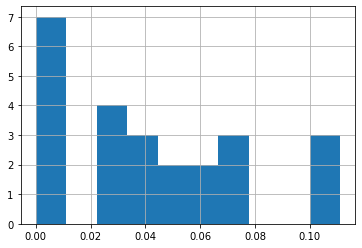

In [448]:
pd.Series(selector.estimator_.feature_importances_.ravel()).hist()

In [449]:
# incA13 = incidenti_A13.apply(pd.to_numeric , errors="coerce")#versione con il coerce che imposta NAN su nulli e non convertibili

In [450]:
#incA13.fillna(-1 , inplace=True)

In [451]:
#X = incA13.drop("totale", axis=1)
#y = incA13["totale"]

In [452]:
X_train,X_test,y_train,y_test = train_test_split(X , y, test_size=0.3)

In [453]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier()

In [454]:
from sklearn.feature_selection import SelectFromModel


selector = SelectFromModel(forest_model)

In [455]:
y_train

19     0
686    0
508    0
87     0
455    0
      ..
13     0
700    0
620    1
894    0
661    0
Name: totale, Length: 587, dtype: int64

In [456]:
selector.fit(X_train , y_train)

SelectFromModel(estimator=RandomForestClassifier())

In [457]:
X_train.columns[selector.get_support() == True]

Index(['provincia', 'comune', 'giorno', 'tipo_veicolo_a',
       'veicolo__a____circostanze_10', 'veicolo__b____circostanze_13',
       'veicolo__a___et__conducente', 'Ora', 'chilometri', 'ettometrica',
       'trimestre'],
      dtype='object')

In [458]:
X_train_13.columns[selector_13.get_support() == True]

Index(['provincia', 'comune', 'giorno', 'tipo_di_strada', 'natura_incidente',
       'tipo_veicolo_a', 'veicolo__a____circostanze_10',
       'veicolo__b____circostanze_13', 'veicolo__a___et__conducente',
       'veicolo__a___patente_condu29', 'Ora', 'chilometri', 'ettometrica'],
      dtype='object')

In [459]:
incidenti_A04.drop(X_train.columns[selector.get_support() == False] , axis=1)

,provincia,comune,giorno,tipo_veicolo_a,veicolo__a____circostanze_10,veicolo__b____circostanze_13,veicolo__a___et__conducente,Ora,chilometri,ettometrica,trimestre,totale
0,17,40,5,1,22,20,1,3,209,750,1,0
4,15,77,5,1,22,20,2,22,137,115,1,0
5,108,52,6,1,72,76,3,8,147,880,1,0
6,108,12,7,1,22,20,1,4,142,600,1,0
7,17,46,3,1,21,20,4,15,204,120,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
964,31,25,3,12,22,20,2,15,503,691,2,0
965,31,25,2,8,20,21,1,17,501,475,2,0
966,32,1,3,1,61,61,1,11,519,352,1,0
967,32,1,5,1,21,20,5,16,521,0,2,0


In [460]:
incidenti_A13.drop(X_train_13.columns[selector_13.get_support() == False] , axis=1)

,provincia,comune,giorno,tipo_di_strada,natura_incidente,tipo_veicolo_a,veicolo__a____circostanze_10,veicolo__b____circostanze_13,veicolo__a___et__conducente,veicolo__a___patente_condu29,Ora,chilometri,ettometrica,totale
0,38,18,5,3,4,1,22,20,4,2,24,29,630,0
1,38,8,1,3,4,1,21,21,3,2,8,43,100,0
2,38,8,1,3,4,8,21,20,4,3,8,47,195,1
3,38,18,5,3,4,8,22,20,1,2,18,28,740,0
4,38,18,3,3,4,1,20,22,2,2,20,30,800,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,37,54,3,3,4,8,22,20,2,2,21,25,395,0
128,37,35,3,1,8,1,61,60,4,2,2,23,0,0
129,37,6,4,3,4,1,21,20,4,2,17,21,610,0
130,37,35,2,3,4,12,0,0,2,3,9,22,300,0


<AxesSubplot:>

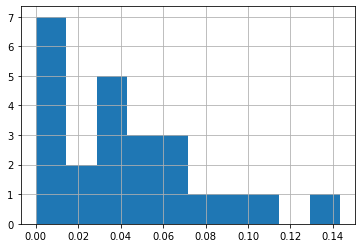

In [461]:
pd.Series(selector.estimator_.feature_importances_.ravel()).hist()

In [462]:
len(selector.estimator_.feature_importances_.ravel()[selector.estimator_.feature_importances_.ravel() > 0.02])

16

### Primi test dei modelli

In [463]:
incidenti_A13["totale"].value_counts()

0    99
1     7
Name: totale, dtype: int64

In [464]:
incidenti_A04["totale"].value_counts()

0    810
1     26
2      3
Name: totale, dtype: int64

In [465]:
incidenti_A04["PROVINCIA"] = incidenti_A04["provincia"].map(df_provincie.set_index("COD_PRO")["PROVINCIA"])
incidenti_A13["PROVINCIA"] = incidenti_A13["provincia"].map(df_provincie.set_index("COD_PRO")["PROVINCIA"])

## PROVE MODELLI DI STEFANO IL KING

In [466]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

forest_model_totale = RandomForestClassifier()
forest_model_totale.fit(X_train_tot, y_train_tot)

score_totale = forest_model_totale.score(X_test_tot, y_test_tot)
print("Score totale:", score_totale)

selector_totale = SelectFromModel(forest_model_totale)
selector_totale.fit(X_train_tot, y_train_tot)
selected_features_totale = X_train_tot.columns[selector_totale.get_support()]
print("Feature selezionate:")
print(selected_features_totale)


Score totale: 0.9647887323943662
Feature selezionate:
Index(['provincia', 'comune', 'giorno', 'condizioni_meteorologiche',
       'tipo_veicolo_a', 'veicolo__a____circostanze_10',
       'veicolo__b____circostanze_13', 'veicolo__a___et__conducente', 'Ora',
       'chilometri', 'ettometrica', 'trimestre'],
      dtype='object')


In [467]:
X_tot_selected_A13 = X_train_13.columns[selector_13.get_support() == True]
X_tot_selected_A4 = X_train.columns[selector_13.get_support() == True]

In [468]:
X_tot_selected_A4 = X_tot[X_tot_selected_A4]
X_tot_selected_A13 = X_tot[X_tot_selected_A13]
forest_model_A4 = RandomForestClassifier()
forest_model_A4.fit(X_tot_selected_A4, y_tot)

forest_model_A13 = RandomForestClassifier()
forest_model_A13.fit(X_tot_selected_A13, y_tot)
score_A4 = forest_model_A4.score(X_tot_selected_A4, y_tot)
score_A13 = forest_model_A13.score(X_tot_selected_A13, y_tot)

# Confronto dei risultati
if score_A4 > score_A13:
    print("Il modello con le feature selezionate dall'Autostrada A4 ha un punteggio più alto.")
else:
    print("Il modello con le feature selezionate dall'Autostrada A13 ha un punteggio più alto.")


Il modello con le feature selezionate dall'Autostrada A13 ha un punteggio più alto.


In [469]:
# FINO A QUESTO PUNTO ABBIAMO VALUTATO QUALE DEI DUE DATASET RIESCE A CONSIDERARE LE FEATURE PIU' RILEVANTI IN MANIERA PIU' ACCURATA,
#DI CONSEGUENZA AVENDO APPLICATO LE FEATURE SU PIU DATI SAPPIAMO CON CERTEZZA QUALI FEATURE SONO PIU' GENERALI.
# VEDIAMO ADESSO PERO' QUALE MODELLO E' RIESCE A GENERALIZZARE MEGLIO , SENZA INCLUDERE TUTTI I DATI TOTALI
# SE IN QUESTA ANALISI OTTENESSIMO CHE IL MODELLO DELLA A13 GENERALIZZASSE MEGLIO ALLORA TUTTO TORNEREBBE.

In [478]:
forest_model_A4 = RandomForestClassifier()
forest_model_A4.fit(X_train, y_train)
score_A4 = forest_model_A4.score(X_test, y_test)
print("Score del modello sulla Autostrada A4:", score_A4)


Score del modello sulla Autostrada A4: 0.9603174603174603


In [479]:
forest_model_A13 = RandomForestClassifier()
forest_model_A13.fit(X_train_13, y_train_13)
score_A13 = forest_model_A13.score(X_test_13, y_test_13)
print("Score del modello sulla Autostrada A13:", score_A13)


Score del modello sulla Autostrada A13: 0.9375


In [480]:
score_A4_tot = forest_model_A4.score(X_test_tot, y_test_tot)
print("Score del modello dell'Autostrada A4 sul test set del dataset totale:", score_A4_tot)


Score del modello dell'Autostrada A4 sul test set del dataset totale: 0.9823943661971831


In [481]:
score_A13_tot = forest_model_A13.score(X_test_tot, y_test_tot)
print("Score del modello dell'Autostrada A13 sul test set del dataset totale:", score_A13_tot)


Score del modello dell'Autostrada A13 sul test set del dataset totale: 0.9753521126760564


In [482]:
# NON TORNA UN CAZZO 

## Plots

### BARH

<AxesSubplot:>

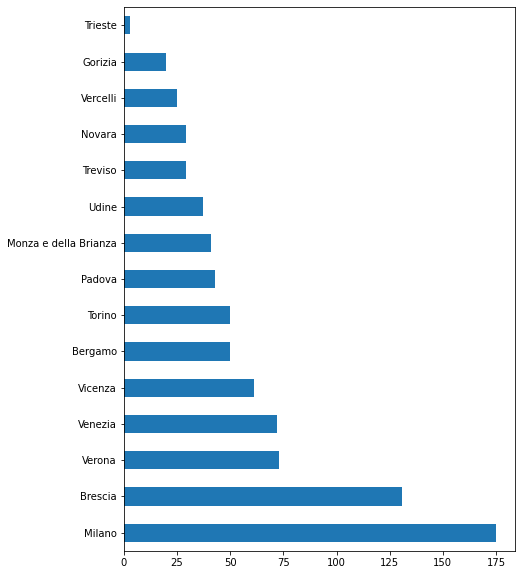

In [ ]:
plt.figure(facecolor='white')
incidenti_A04.PROVINCIA.value_counts().plot.barh(figsize = (7,10))#plot della quantità di incidenti per provincia

<AxesSubplot:>

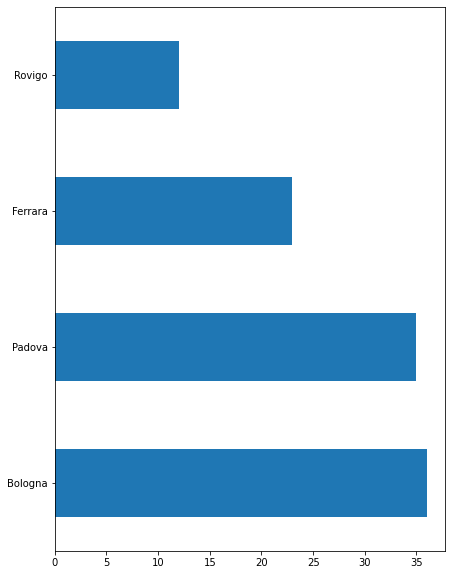

In [ ]:
plt.figure(facecolor='white')
incidenti_A13.PROVINCIA.value_counts().plot.barh(figsize = (7,10))#plot della quantità di incidenti per provincia

In [ ]:
incidenti_A04["isMortale"] = incidenti_A04["totale"] # generalizzazione del numero di morti
incidenti_A04 = incidenti_A04.drop("totale", axis=1)
incidenti_A04.isMortale = incidenti_A04.isMortale.apply(lambda x: 1 if x > 0 else 0)
incidenti_A04.isMortale.value_counts()

0    810
1     29
Name: isMortale, dtype: int64

In [ ]:
incidenti_A13["isMortale"] = incidenti_A13["totale"] # generalizzazione del numero di morti
incidenti_A13 = incidenti_A13.drop("totale", axis=1)
incidenti_A13.isMortale = incidenti_A13.isMortale.apply(lambda x: 1 if x > 0 else 0)
incidenti_A13.isMortale.value_counts()

0    99
1     7
Name: isMortale, dtype: int64

### Stacked Bar

In [ ]:
incidenti_A04.groupby(by=["PROVINCIA", "isMortale"]).count().provincia.unstack().columns

Int64Index([0, 1], dtype='int64', name='isMortale')

In [ ]:
incidenti_A04.groupby(by=["PROVINCIA", "isMortale"]).count().provincia.sort_values()

PROVINCIA              isMortale
Padova                 1              1
Monza e della Brianza  1              1
Novara                 1              2
Verona                 1              2
Vercelli               1              2
Trieste                0              3
Treviso                1              3
Udine                  1              3
Vicenza                1              3
Brescia                1              3
Venezia                1              4
Milano                 1              5
Gorizia                0             20
Vercelli               0             23
Treviso                0             26
Novara                 0             27
Udine                  0             34
Monza e della Brianza  0             40
Padova                 0             42
Bergamo                0             50
Torino                 0             50
Vicenza                0             58
Venezia                0             68
Verona                 0             71
Brescia

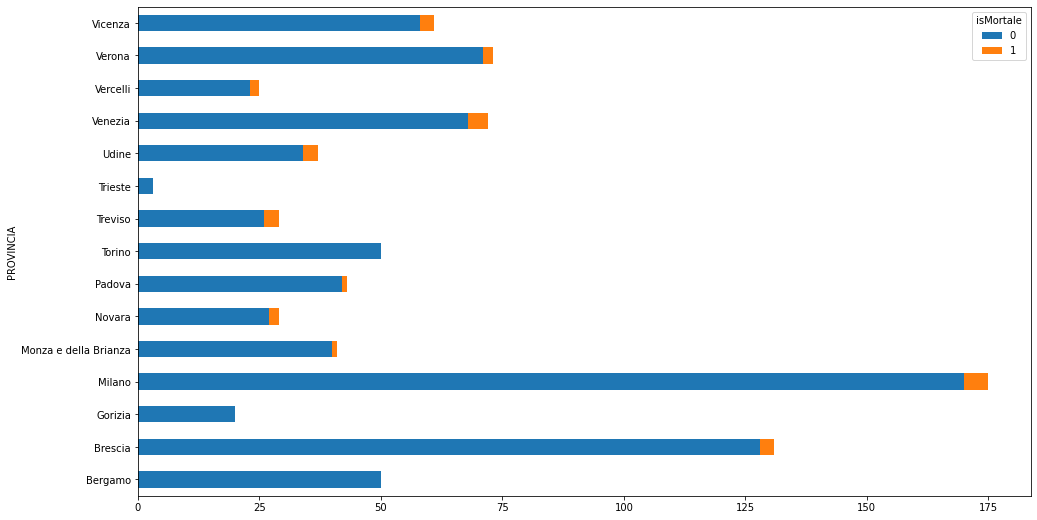

In [ ]:
incidenti_A04.groupby(by=["PROVINCIA", "isMortale"]).count().provincia.unstack().plot.barh(stacked=True, figsize=(16, 9))
plt.show()

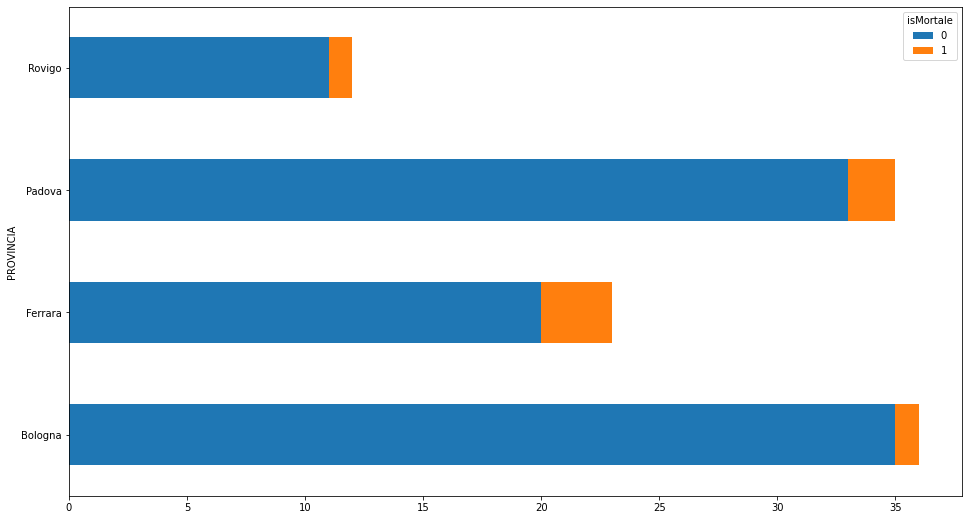

In [ ]:
incidenti_A13.groupby(by=["PROVINCIA", "isMortale"]).count().provincia.unstack().plot.barh(stacked=True, figsize=(16, 9))
plt.show()

<AxesSubplot:ylabel='PROVINCIA'>

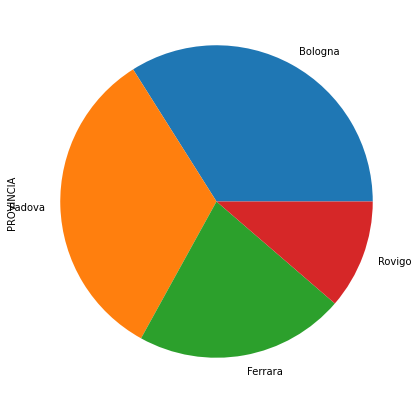

In [ ]:
plt.figure(facecolor='white')
incidenti_A13.PROVINCIA.value_counts().plot.pie(figsize = (7,10))#plot della quantità di incidenti per provincia

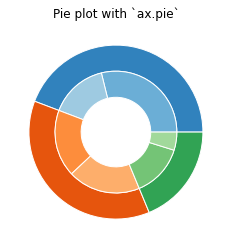

In [ ]:
fig, ax = plt.subplots()

size = 0.3
vals = np.array([[60., 32.], [37., 40.], [29., 10.]])

cmap = plt.colormaps["tab20c"]
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap([1, 2, 5, 6, 9, 10])

ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Pie plot with `ax.pie`')
plt.show()

In [ ]:
incidenti_A04[incidenti_A04.totale == 0]["PROVINCIA"].value_counts()

AttributeError: 'DataFrame' object has no attribute 'totale'

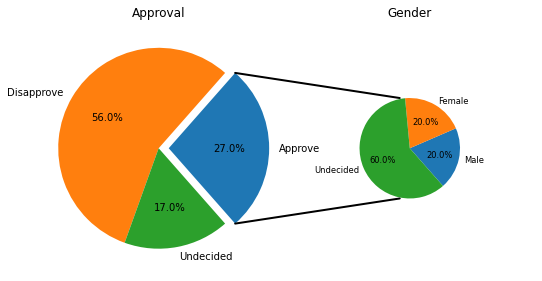

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np

# make figure and assign axis objects
fig = plt.figure(figsize=(9, 5.0625))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.subplots_adjust(wspace=0)

# large pie chart parameters
ratios = [.27, .56, .17]
labels = ['Approve', 'Disapprove', 'Undecided']
explode = [0.1, 0, 0]
# rotate so that first wedge is split by the x-axis
angle = -180 * ratios[0]
ax1.pie(ratios, autopct='%1.1f%%', startangle=angle,
        labels=labels, explode=explode)

# small pie chart parameters
ratios = [.20, .20, .60]
labels = ['Male', 'Female', 'Undecided']
width = .2

ax2.pie(ratios, autopct='%1.1f%%', startangle=angle,
        labels=labels, radius=0.5, textprops={'size': 'smaller'})

ax1.set_title('Approval')
ax2.set_title('Gender')

# use ConnectionPatch to draw lines between the two plots
# get the wedge data
theta1, theta2 = ax1.patches[0].theta1, ax1.patches[0].theta2
center, r = ax1.patches[0].center, ax1.patches[0].r

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(- width / 2, .5), xyB=(x, y),
                      coordsA="data", coordsB="data", axesA=ax2, axesB=ax1)
con.set_color([0, 0, 0])
con.set_linewidth(2)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(- width / 2, -.5), xyB=(x, y), coordsA="data",
                      coordsB="data", axesA=ax2, axesB=ax1)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(2)

plt.show()